Animating oil dispersion on the Salish Sea Atlantis grid. Original code written by Bec Gordon & Javier Porobic, CSIRO, modified to create an animated GIF

In [1]:
import os
import xarray as xr

import numpy as np
import geopandas as gpd

import matplotlib.path as mplPath
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)

boxes = data_df['BOTZ']
land_boxes = boxes==0
land_boxes = data_df.index[land_boxes]

In [3]:
# Reading in the file generated by Ocean Parcels

parcelsFileName = '5b_Turn_Point_Diluted_bitumen_decay_test1.nc'

pfile = xr.open_dataset(str(parcelsFileName), decode_cf=True)

lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)
z = np.ma.filled(pfile.variables['z'], np.nan)
probs = np.ma.filled(pfile.variables['decay_value'], np.nan)

print(lon.shape)
numParticles = lon.shape[0]

(100, 145)


In [4]:
# Defining particle dispersion period

trackDates = [];

for i in range(0,numParticles):
    #print(time[i][0])
    #trackDates.append( dateutil.parser.parse(time[i][0]))
    trackDates.append(time[i][0])

RDiff = (max(trackDates) - min(trackDates))

minDate = np.datetime64("2018-01-01T00:00:00");
outputDT = 60*60 #1 hour

stepsPerDay = int(86400.0/ outputDT); 
numStepsPerDT = int(outputDT/3600.0);
trackLength = len(lon[0]);
numReleaseDays = RDiff;
#print('numReleaseDays = ' + str(numReleaseDays))

numReleaseDTS = int(abs(numReleaseDays/np.timedelta64(1, 'h')));
totalNumOfTS = int(numReleaseDTS + trackLength);
print('totalNumOfTS = ' + str(totalNumOfTS))
print('trackLength = ' + str(trackLength))

#numParticles = 1
print(numParticles)

totalNumOfTS = 168
trackLength = 145
100


In [5]:
trackLonsPadded = np.zeros((int(numParticles), totalNumOfTS));
trackLatsPadded = np.zeros((int(numParticles), totalNumOfTS));
particlesAge = np.zeros((int(numParticles), totalNumOfTS));

for trackIndex in range(0,numParticles):

    #print(trackDates[trackIndex])
    #print(minDate)
    trackDateDiff = trackDates[trackIndex] - minDate

    #print(trackDateDiff/np.timedelta64(1, 'h'))

    #trackNumsToPad = int(abs((trackDateDiff.seconds/stepSeconds))) + int(abs((trackDateDiff.days * stepDays)));
    trackNumsToPad = int(trackDateDiff/np.timedelta64(1, 'h'))
    #print(trackNumsToPad)
    #trackNumsToPad = 0

    #print trackNumsToPad

    trackLonsPadded[trackIndex][0:trackNumsToPad] = 0;
    trackLatsPadded[trackIndex][0:trackNumsToPad] = 0;

    trackLonsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lon[:][trackIndex];
    trackLatsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lat[:][trackIndex];

#print(trackLonsPadded)
#print('trackLength = ' + str(trackLength))
#print('numStepsPerDT = ' + str(numStepsPerDT))
numSteps = int(trackLength / numStepsPerDT)

ValueError: could not broadcast input array from shape (145,) into shape (144,)

In [6]:
# Reading in Atlantis-specific files

Atlantis_FileName = 'Atlantis_decay_test1.nc'
savefile_prefix = 'boxes'

pfile = xr.open_dataset(str(Atlantis_FileName), decode_cf=True)

print(pfile)

time = np.ma.filled(pfile.variables['time'], np.nan)

scale = 1e40
oil = np.ma.filled(pfile.variables['oil'], np.nan) 
benzo = np.ma.filled(pfile.variables['Benzo'], np.nan)
naph = np.ma.filled(pfile.variables['Naphthalene'], np.nan) 
oil = oil*scale 
num_steps = time.shape[0]
print(num_steps)


<xarray.Dataset>
Dimensions:       (t: 169, b: 130)
Dimensions without coordinates: t, b
Data variables:
    time          (t) datetime64[ns] ...
    oil           (t, b) float32 ...
    Naphthalene   (t, b) float32 ...
    Phenanthrene  (t, b) float32 ...
    Pyrene        (t, b) float32 ...
    Benzo         (t, b) float32 ...
169


In [7]:
# Adding a log scale so the boxes show the proportion of contamination

import matplotlib.colors as colors

_cmap = cm.coolwarm #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]

for time_index in range(0, num_steps):

    plon = trackLonsPadded[:, time_index]
    plat = trackLatsPadded[:, time_index]

    plon = plon[plon<0]
    plat = plat[plat>0]
    time_oil = oil[time_index]
    #print(time_oil)

    data_df['oil'] = time_oil
    data_df.loc[land_boxes, 'oil'] = 1

    #print(data_df['oil'])
    ax = data_df.plot(figsize=(9, 15), column = 'oil', cmap=_cmap, norm=colors.SymLogNorm(
        linthresh=0.000001, linscale=0.000001,
        vmin=-0.0001, vmax=1e10, base=10),
        legend=True, legend_kwds={'label': "Relative Oil Concentration"
        },)

    land_df.plot(ax=ax, color='white')
    ax.scatter(plon, plat, s=0.001, color='lightgrey', zorder=20)
    
    ax.set_title(time[time_index])

    #plt.tight_layout()
    plot_name = savefile_prefix + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

IndexError: index 168 is out of bounds for axis 1 with size 168

In [8]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = 'Oil_Scenario_5b_TurnPoint_decaytest1.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

0

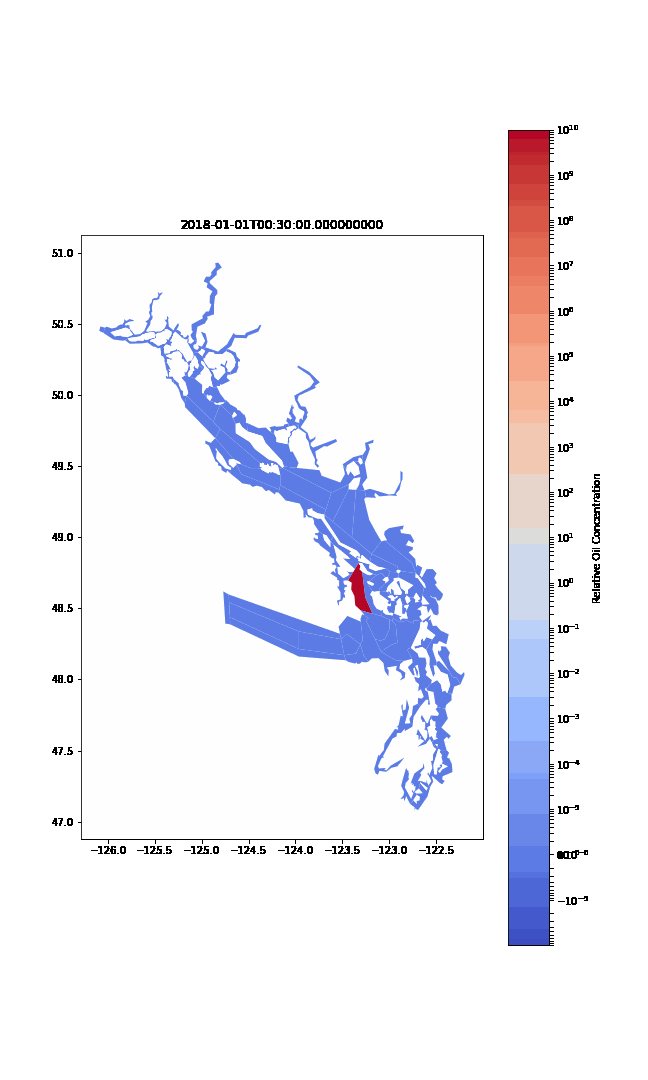

In [9]:
from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))

In [ ]:


fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.loglog(time,oil);

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.plot(time,oil);

In [ ]:
np.histogram(benzo)


In [ ]:

flat_oil = np.ndarray.flatten(oil)
np.histogram(flat_oil)

In [ ]:
flat_oil.shape
fig, ax = plt.subplots(1,1)
ax.hist(flat_oil)
ax.set_yscale("log")